In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/train_dat/train_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/train_dat')

In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt

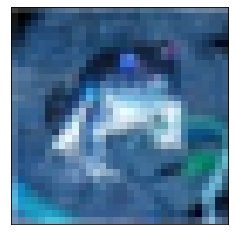

In [ ]:
# Example image plot
img1 = cv2.imread('/content/drive/MyDrive/train_dat/images/{:05d}.png'.format(1))
plt.imshow(img1)
plt.xticks([]) ## remove the ticks on x-axis
plt.yticks([]) ## remove the ticks on y-axis
plt.show()

In [2]:

noisy = pd.read_csv('/content/drive/MyDrive/train_dat/noisy_labels.csv',header=None)
clean = pd.read_csv('/content/drive/MyDrive/train_dat/clean_labels.csv',header=None)


In [6]:
images = []
for i in range(1,10001):
  images.append(cv2.imread('/content/drive/MyDrive/train_dat/images/{:05d}.png'.format(i)))
  if i % 100 == 0:
    print(i)
images = torch.Tensor(np.stack(images))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [7]:
sz = 50
images_trainloader = torch.utils.data.DataLoader(images[:6000], batch_size=sz)
noisylabel_trainloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[:6000].values).long()), batch_size=sz)
label_trainloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[:6000].values).long()), batch_size=sz)

images_valoader = torch.utils.data.DataLoader(images[6000:8000], batch_size=sz)
noisylabel_valoader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[6000:8000].values).long()), batch_size=sz)
label_valoader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[6000:8000].values).long()), batch_size=sz)

images_testloader = torch.utils.data.DataLoader(images[8000:10000], batch_size=sz)
noisylabel_testloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[8000:10000].values).long()), batch_size=sz)
label_testloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[8000:10000].values).long()), batch_size=sz)



In [67]:
nclass = 10
class MyCNN(nn.Module):
    def __init__(self,num_class):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8 + num_class, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_class)
        self.sm1 = nn.Softmax(1)
        self.num_class = num_class

    def forward(self, x,y):
        y = torch.Tensor(y)
        
        x = x.permute(0,3,1,2)
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.reshape(x.shape[0],32*8*8)
        # print(x.shape,torch.Tensor(y).shape)
        x = torch.cat((x, y), dim=1)
        
        x = x.reshape(-1, 32 * 8 * 8 + self.num_class)
        x = self.fc1(x.float())
        
        x = self.bn3(x)
        
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sm1(x)
        return x



model = MyCNN(nclass)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.L1Loss()
criterion = nn.CrossEntropyLoss()

In [73]:
num_epochs = 75
patience = 3
best_val_loss = float('inf')
epochs_since_improvement = 0

# add .float() when using crossentropyloss

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (d, nl, l) in enumerate(zip(images_trainloader, noisylabel_trainloader, label_trainloader), 1):
        optimizer.zero_grad()
        outputs = model(d, nl)
        loss = criterion(outputs, l.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(images_trainloader)))
    
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for j, (val_d, val_nl, val_l) in enumerate(zip(images_valoader, noisylabel_valoader, label_valoader), 1):
            val_outputs = model(val_d, val_nl)
            val_loss += criterion(val_outputs, val_l.float()).item()
            _, predicted = torch.max(val_outputs.data, 1)
            _, gt = torch.max(val_l.data, 1)
            total += val_l.size(0)
            correct += (predicted == gt).sum().item()
        val_loss /= len(images_valoader)
        val_acc = 100 * correct / total
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, num_epochs, val_loss, val_acc))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        
    if epochs_since_improvement > patience:
        print('Stopping training after {} epochs without improvement'.format(epochs_since_improvement))
        break


Epoch [1/75], Training Loss: 2.1928
Epoch [1/75], Validation Loss: 2.1688, Validation Accuracy: 30.15%
Epoch [2/75], Training Loss: 2.1292
Epoch [2/75], Validation Loss: 2.1342, Validation Accuracy: 32.40%
Epoch [3/75], Training Loss: 2.0966
Epoch [3/75], Validation Loss: 2.1158, Validation Accuracy: 33.95%
Epoch [4/75], Training Loss: 2.0707
Epoch [4/75], Validation Loss: 2.1027, Validation Accuracy: 35.75%
Epoch [5/75], Training Loss: 2.0543
Epoch [5/75], Validation Loss: 2.0867, Validation Accuracy: 37.90%
Epoch [6/75], Training Loss: 2.0384
Epoch [6/75], Validation Loss: 2.0769, Validation Accuracy: 38.25%
Epoch [7/75], Training Loss: 2.0208
Epoch [7/75], Validation Loss: 2.0785, Validation Accuracy: 37.75%
Epoch [8/75], Training Loss: 2.0102
Epoch [8/75], Validation Loss: 2.0722, Validation Accuracy: 38.40%
Epoch [9/75], Training Loss: 2.0025
Epoch [9/75], Validation Loss: 2.0619, Validation Accuracy: 39.90%
Epoch [10/75], Training Loss: 1.9889
Epoch [10/75], Validation Loss: 2.06

In [82]:
# evaluation on test set
def evaluator(model,images_testloader, noisylabel_testloader, label_testloader):
  correct = 0
  total = 0
  for t, (t_d, t_nl, t_l) in enumerate(zip(images_testloader, noisylabel_testloader, label_testloader), 1):
    test_outputs = model(t_d, t_nl)
    correct += sum(torch.argmax(test_outputs, dim=1) == torch.argmax(t_l, dim=1))
    total += len(t_l)
  accuracy = correct / total
  print('Accuracy on the test set: %f' % (correct / total))
  return accuracy

In [83]:
def evaluator_th(model,threshold,it,nlt,lt):
  correct = 0
  total = 0

  # set a confidence threshold, which if not passed, means you just pick the original noisy label
  for t, (t_d, t_nl, t_l) in enumerate(zip(it, nlt, lt), 1):
    test_outputs = model(t_d, t_nl)
    max_vals, max_indices = torch.max(test_outputs, dim=1)
    predictions = torch.Tensor([torch.argmax(test_outputs[i]) if max_vals[i] > threshold else torch.argmax(t_nl[i]) for i in range(len(t_nl))]).long()
    # preds = torch.zeros_like(test_outputs).scatter_(1, torch.argmax(test_outputs, dim=1).unsqueeze(1), 1)
    correct += sum(predictions == torch.argmax(t_l, dim=1))
    total += len(t_l)
  accuracy = correct / total
  print('Accuracy on the test set: %f with threshold %f' % (correct / total, threshold))
  return accuracy

In [89]:
testacc = evaluator(model,images_testloader, noisylabel_testloader, label_testloader)
testacc2 = evaluator_th(model,0.9,images_testloader, noisylabel_testloader, label_testloader)

In [97]:
# benchmark
np.mean(noisy[0][:10000] == clean[0])

0.3968

In [85]:
# A slightly more complex network than the base
nclass = 10
class MyCNN2(nn.Module):
    def __init__(self,num_class):
        super(MyCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8 + num_class, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_class)
        self.sm1 = nn.Softmax(1)
        self.num_class = num_class

    def forward(self, x,y):
        y = torch.Tensor(y)
        
        x = x.permute(0,3,1,2)
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.reshape(x.shape[0],64*8*8)
        # print(x.shape,torch.Tensor(y).shape)
        x = torch.cat((x, y), dim=1)
        
        x = x.reshape(-1, 64 * 8 * 8 + self.num_class)
        x = self.fc1(x.float())
        
        x = self.bn3(x)
        
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sm1(x)
        return x



model = MyCNN2(nclass)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [86]:
num_epochs = 75
patience = 3
best_val_loss = float('inf')
epochs_since_improvement = 0

# add .float() when using crossentropyloss

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (d, nl, l) in enumerate(zip(images_trainloader, noisylabel_trainloader, label_trainloader), 1):
        optimizer.zero_grad()
        outputs = model(d, nl)
        loss = criterion(outputs, l.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(images_trainloader)))
    
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for j, (val_d, val_nl, val_l) in enumerate(zip(images_valoader, noisylabel_valoader, label_valoader), 1):
            val_outputs = model(val_d, val_nl)
            val_loss += criterion(val_outputs, val_l.float()).item()
            _, predicted = torch.max(val_outputs.data, 1)
            _, gt = torch.max(val_l.data, 1)
            total += val_l.size(0)
            correct += (predicted == gt).sum().item()
        val_loss /= len(images_valoader)
        val_acc = 100 * correct / total
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, num_epochs, val_loss, val_acc))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        
    if epochs_since_improvement > patience:
        print('Stopping training after {} epochs without improvement'.format(epochs_since_improvement))
        break


Epoch [1/75], Training Loss: 2.2688
Epoch [1/75], Validation Loss: 2.2435, Validation Accuracy: 26.85%
Epoch [2/75], Training Loss: 2.1562
Epoch [2/75], Validation Loss: 2.1383, Validation Accuracy: 33.60%
Epoch [3/75], Training Loss: 2.0867
Epoch [3/75], Validation Loss: 2.0910, Validation Accuracy: 37.90%
Epoch [4/75], Training Loss: 2.0505
Epoch [4/75], Validation Loss: 2.0645, Validation Accuracy: 40.75%
Epoch [5/75], Training Loss: 2.0213
Epoch [5/75], Validation Loss: 2.0454, Validation Accuracy: 42.20%
Epoch [6/75], Training Loss: 2.0013
Epoch [6/75], Validation Loss: 2.0343, Validation Accuracy: 42.25%
Epoch [7/75], Training Loss: 1.9818
Epoch [7/75], Validation Loss: 2.0250, Validation Accuracy: 43.65%
Epoch [8/75], Training Loss: 1.9637
Epoch [8/75], Validation Loss: 2.0142, Validation Accuracy: 44.80%
Epoch [9/75], Training Loss: 1.9492
Epoch [9/75], Validation Loss: 2.0123, Validation Accuracy: 45.15%
Epoch [10/75], Training Loss: 1.9366
Epoch [10/75], Validation Loss: 2.00

In [87]:
testacc = evaluator(model,images_testloader, noisylabel_testloader, label_testloader)
testacc2 = evaluator_th(model,0.9,images_testloader, noisylabel_testloader, label_testloader)

Accuracy on the test set: 0.520000
Accuracy on the test set: 0.531000 with threshold 0.900000


In [ ]:
# sample data to test the network

#noisylabel_loader
# nn.functional.one_hot(torch.Tensor(noisy[0].iloc[:10000].values).long())
#label_loader
# nn.functional.one_hot(torch.Tensor(clean[0].values).long())

import random
# batch size 4
sz = 4
trainloader = torch.utils.data.DataLoader(torch.Tensor(np.random.rand(8,32,32,3)), batch_size=sz)
# number of classes 10
nclass = 10

ys = np.zeros(shape=(8,nclass))
for i in range(ys.shape[0]):
  labs = np.zeros(nclass)
  labs[random.randint(0,nclass-1)] = 1
  ys[i] = labs
noisylabel_loader = torch.utils.data.DataLoader(ys, batch_size=sz)

ys = np.zeros(shape=(8,nclass))
for i in range(ys.shape[0]):
  labs = np.zeros(nclass)
  labs[random.randint(0,nclass-1)] = 1
  ys[i] = labs
label_loader = torch.utils.data.DataLoader(ys, batch_size=sz)

for i, (d, nl, l) in enumerate(zip(trainloader,noisylabel_loader,label_loader),0):
  print(i,d.shape,nl.shape,l.shape)

0 torch.Size([4, 32, 32, 3]) torch.Size([4, 10]) torch.Size([4, 10])
1 torch.Size([4, 32, 32, 3]) torch.Size([4, 10]) torch.Size([4, 10])
